In [1]:
# !pip install opencv-python numpy matplotlib

import cv2 as cv
import numpy as np
import json
import json
from IPython.display import display, Image
import PIL.Image

In [2]:
def detect_shapes(image_path: str, output_path: str,
                  border_px: int = 10, min_area: int = 500,
                  color_tol: int = 25, texture_thresh: float = 15.0):
    """
    Detect shapes on a grassy background using:
      - Texture: grass = high variance (detailed), shapes = smooth
      - Color: grass is estimated from borders
      - Combined grass mask = similar color + high texture
      - Shapes = not grass
    """
    img = cv.imread(image_path, cv.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    h, w = img.shape[:2]
    out = img.copy()


    lab = cv.cvtColor(img, cv.COLOR_BGR2LAB).astype(np.float32)
    L, a, b = cv.split(lab)

    def border_vals(channel):
        return np.concatenate([
            channel[:border_px, :].ravel(),
            channel[-border_px:, :].ravel(),
            channel[:, :border_px].ravel(),
            channel[:, -border_px:].ravel()
        ])

    L_bg = np.median(border_vals(L))
    a_bg = np.median(border_vals(a))
    b_bg = np.median(border_vals(b))


    dist_color = np.sqrt((L - L_bg)**2 + (a - a_bg)**2 + (b - b_bg)**2)

    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    lap = cv.Laplacian(gray, cv.CV_64F, ksize=3)
    texture = cv.convertScaleAbs(lap)


    mask_grass = (dist_color < color_tol) & (texture > texture_thresh)
    mask_grass = mask_grass.astype(np.uint8) * 255


    shapes_mask = cv.bitwise_not(mask_grass)


    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5,5))
    shapes_mask = cv.morphologyEx(shapes_mask, cv.MORPH_OPEN, kernel, iterations=2)
    shapes_mask = cv.morphologyEx(shapes_mask, cv.MORPH_CLOSE, kernel, iterations=2)


    contours, _ = cv.findContours(shapes_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        area = cv.contourArea(cnt)
        if area < min_area:
            continue


        cv.drawContours(out, [cnt], -1, (0, 255, 0), 2)


        M = cv.moments(cnt)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            cv.circle(out, (cx, cy), 5, (0, 0, 255), -1)

    cv.imwrite(output_path, out)
    print(f"Shapes detected and saved at {output_path}")

In [3]:
def process_frame(frame, border_px=10, min_area=500, color_tol=25, texture_thresh=15.0):
    """Apply texture+color algorithm to a single frame."""
    h, w = frame.shape[:2]
    out = frame.copy()


    lab = cv.cvtColor(frame, cv.COLOR_BGR2LAB).astype(np.float32)
    L, a, b = cv.split(lab)

    def border_vals(channel):
        return np.concatenate([
            channel[:border_px, :].ravel(),
            channel[-border_px:, :].ravel(),
            channel[:, :border_px].ravel(),
            channel[:, -border_px:].ravel()
        ])
    a_bg = np.median(border_vals(a))
    b_bg = np.median(border_vals(b))
    L_bg = np.median(border_vals(L))

    dist_color = np.sqrt((L - L_bg)**2 + (a - a_bg)**2 + (b - b_bg)**2)


    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    lap = cv.Laplacian(gray, cv.CV_64F, ksize=3)
    texture = cv.convertScaleAbs(lap)


    mask_grass = (dist_color < color_tol) & (texture > texture_thresh)
    mask_grass = mask_grass.astype(np.uint8) * 255


    shapes_mask = cv.bitwise_not(mask_grass)


    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5,5))
    shapes_mask = cv.morphologyEx(shapes_mask, cv.MORPH_OPEN, kernel, iterations=2)
    shapes_mask = cv.morphologyEx(shapes_mask, cv.MORPH_CLOSE, kernel, iterations=2)


    contours, _ = cv.findContours(shapes_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        area = cv.contourArea(cnt)
        if area < min_area:
            continue
        cv.drawContours(out, [cnt], -1, (0, 255, 0), 2)
        M = cv.moments(cnt)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            cv.circle(out, (cx, cy), 5, (0, 0, 255), -1)

    return out 




In [4]:
if __name__ == "__main__":
    detect_shapes("STATIC.png", "output_shapes_texture.png")

Shapes detected and saved at output_shapes_texture.png


In [5]:
def detect_shapes_video(video_path: str, output_path: str,
                        border_px=10, min_area=500,
                        color_tol=25, texture_thresh=15.0):
    """Process video stream frame-by-frame and save annotated video."""
    cap = cv.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError(f"Cannot open video: {video_path}")


    fps = cap.get(cv.CAP_PROP_FPS)
    width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv.VideoWriter_fourcc(*"mp4v")
    out_writer = cv.VideoWriter(output_path, fourcc, fps, (width, height))

    print(f"Processing video {video_path} → {output_path}")
    while True:
        ret, frame = cap.read()
        if not ret:
            break


        processed = process_frame(frame,
                                  border_px=border_px,
                                  min_area=min_area,
                                  color_tol=color_tol,
                                  texture_thresh=texture_thresh)


        out_writer.write(processed)


    cap.release()
    out_writer.release()

    print(f"Finished. Saved output video at {output_path}")

In [6]:
if __name__ == "__main__":
    detect_shapes_video("DYNAMIC_EASY.mp4", "output_dynamic_easy.mp4")

Processing video DYNAMIC_EASY.mp4 → output_dynamic_easy.mp4
Finished. Saved output video at output_dynamic_easy.mp4


Detections JSON: [
  {
    "pixel": [
      1911,
      1029
    ],
    "world_in": [
      851.012275584724,
      457.2772796606978,
      1141.9501209121927
    ]
  },
  {
    "pixel": [
      1907,
      864
    ],
    "world_in": [
      821.5807720869165,
      371.45176578295315,
      1104.7692326482486
    ]
  },
  {
    "pixel": [
      713,
      715
    ],
    "world_in": [
      481.06817402946945,
      481.4068319576196,
      1730.1712599391722
    ]
  },
  {
    "pixel": [
      1365,
      773
    ],
    "world_in": [
      108.2025212158569,
      61.14674367956125,
      203.27160961429712
    ]
  },
  {
    "pixel": [
      608,
      722
    ],
    "world_in": [
      47.954332654722535,
      56.82645718258129,
      202.25360418474324
    ]
  },
  {
    "pixel": [
      1910,
      369
    ],
    "world_in": [
      745.4428122305941,
      143.7131277905538,
      1000.8130541456546
    ]
  },
  {
    "pixel": [
      1736,
      392
    ],
    "world_in": [
  

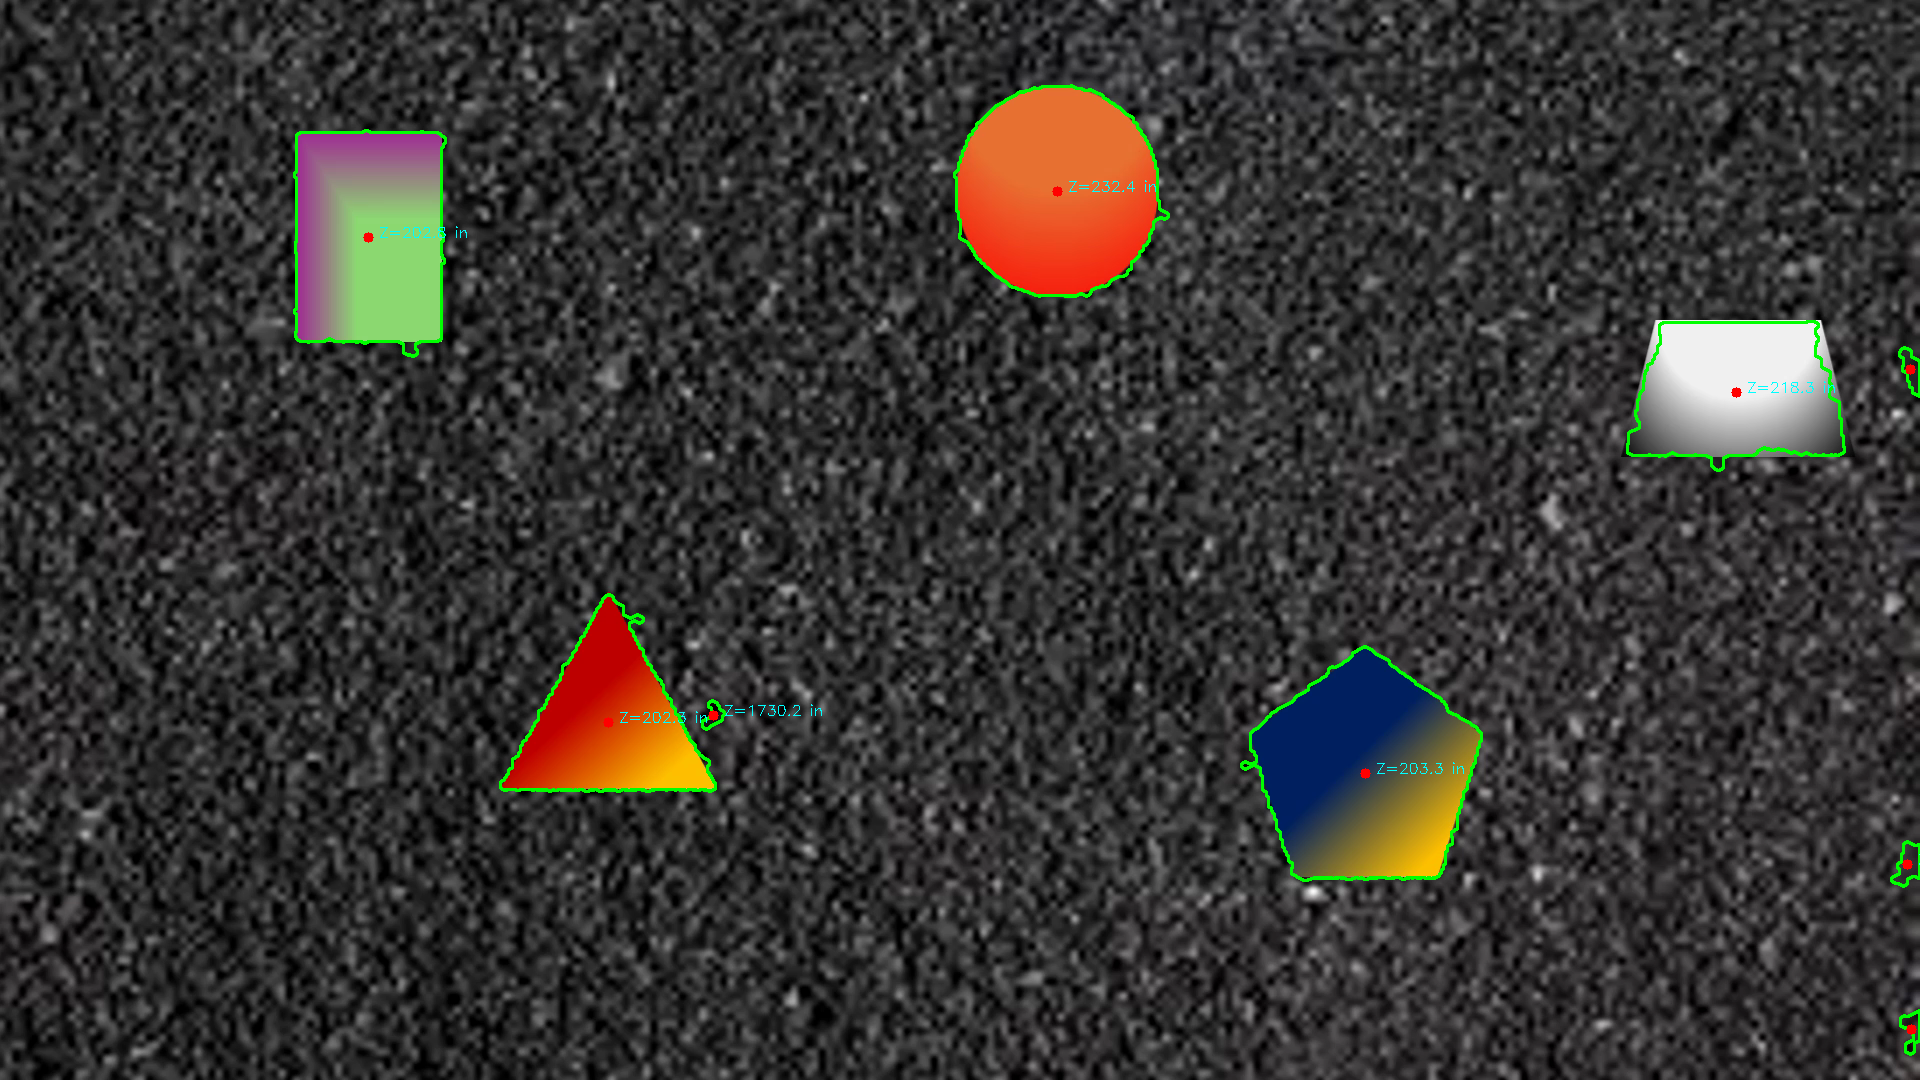

In [7]:


# Intrinsics
K = np.array([[2564.3186869, 0, 0],
              [0, 2569.70273111, 0],
              [0, 0, 1]])
fx, fy = K[0, 0], K[1, 1]
cx, cy = K[0, 2], K[1, 2]
R_real = 10.0  # in

def pixel_to_camera(u, v, r_px):
    if r_px <= 0: return None
    Z = (fx * R_real) / r_px
    X = (u - cx) * Z / fx
    Y = (v - cy) * Z / fy
    return X, Y, Z

def detect_shapes(frame):
    out = frame.copy()
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
    s = hsv[:, :, 1]
    lap = cv.Laplacian(gray, cv.CV_64F, ksize=3)
    texture = cv.convertScaleAbs(lap)

    # Asphalt mask
    mask_asphalt = (s < 30) & (texture > 15)
    mask_asphalt = mask_asphalt.astype(np.uint8) * 255
    shapes_mask = cv.bitwise_not(mask_asphalt)

    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5,5))
    shapes_mask = cv.morphologyEx(shapes_mask, cv.MORPH_OPEN, kernel, iterations=2)
    shapes_mask = cv.morphologyEx(shapes_mask, cv.MORPH_CLOSE, kernel, iterations=2)

    detections = []
    contours, _ = cv.findContours(shapes_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        area = cv.contourArea(cnt)
        if area < 300: continue
        (x, y), r_px = cv.minEnclosingCircle(cnt)
        M = cv.moments(cnt)
        if M["m00"] == 0: continue
        cx_px, cy_px = int(M["m10"]/M["m00"]), int(M["m01"]/M["m00"])

        coords = pixel_to_camera(cx_px, cy_px, r_px)
        if coords is None: continue
        X, Y, Z = coords
        detections.append({"pixel": [cx_px, cy_px], "world_in": [X, Y, Z]})

        cv.drawContours(out, [cnt], -1, (0,255,0), 2)
        cv.circle(out, (cx_px, cy_px), 5, (0,0,255), -1)
        cv.putText(out, f"Z={Z:.1f} in", (cx_px+10, cy_px),
                   cv.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,0), 1)
    return out, detections

# ---- Example: run on first frame of video ----
cap = cv.VideoCapture("DYNAMIC_HARD.mp4")
ret, frame = cap.read()
cap.release()

if ret:
    annotated, dets = detect_shapes(frame)
    print("Detections JSON:", json.dumps(dets, indent=2))

    # show in notebook
    img_rgb = cv.cvtColor(annotated, cv.COLOR_BGR2RGB)
    display(PIL.Image.fromarray(img_rgb))

In [8]:
# Camera intrinsics
K = np.array([[2564.3186869, 0, 0],
              [0, 2569.70273111, 0],
              [0, 0, 1]])
fx, fy = K[0, 0], K[1, 1]
cx, cy = K[0, 2], K[1, 2]

# Known real-world circle radius (inches)
R_real = 10.0  # inches

def pixel_to_camera(u, v, r_px):
    """Convert 2D pixel centroid + radius to 3D camera coordinates."""
    if r_px <= 0:
        return None
    Z = (fx * R_real) / r_px   # depth from pinhole model
    X = (u - cx) * Z / fx
    Y = (v - cy) * Z / fy
    return X, Y, Z

def process_frame_asphalt_3d(frame,
                             sat_thresh=30, texture_thresh=15,
                             min_area=300, solidity_thresh=0.8,
                             variance_thresh=150.0):
    """Detect shapes and compute 3D coords of centroids."""
    out = frame.copy()
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
    s = hsv[:, :, 1]
    lap = cv.Laplacian(gray, cv.CV_64F, ksize=3)
    texture = cv.convertScaleAbs(lap)

    # Asphalt mask
    mask_asphalt = (s < sat_thresh) & (texture > texture_thresh)
    mask_asphalt = mask_asphalt.astype(np.uint8) * 255
    shapes_mask = cv.bitwise_not(mask_asphalt)

    # Morph cleanup
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5,5))
    shapes_mask = cv.morphologyEx(shapes_mask, cv.MORPH_OPEN, kernel, iterations=2)
    shapes_mask = cv.morphologyEx(shapes_mask, cv.MORPH_CLOSE, kernel, iterations=2)

    results = []
    contours, _ = cv.findContours(shapes_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        area = cv.contourArea(cnt)
        if area < min_area:
            continue

        # Check solidity
        hull = cv.convexHull(cnt)
        if cv.contourArea(hull) == 0:
            continue
        solidity = area / cv.contourArea(hull)
        if solidity < solidity_thresh:
            continue

        # Compute centroid + enclosing circle
        (x, y), r_px = cv.minEnclosingCircle(cnt)
        M = cv.moments(cnt)
        if M["m00"] == 0:
            continue
        cx_px = int(M["m10"] / M["m00"])
        cy_px = int(M["m01"] / M["m00"])

        coords = pixel_to_camera(cx_px, cy_px, r_px)
        if coords is None:
            continue
        X, Y, Z = coords
        results.append((cx_px, cy_px, X, Y, Z))

        # Draw
        cv.drawContours(out, [cnt], -1, (0, 255, 0), 2)
        cv.circle(out, (cx_px, cy_px), 5, (0, 0, 255), -1)
        cv.putText(out, f"X={X:.1f}, Y={Y:.1f}, Z={Z:.1f} in",
                   (cx_px+10, cy_px),
                   cv.FONT_HERSHEY_SIMPLEX, 0.5,
                   (255, 255, 0), 1, cv.LINE_AA)

    return out, results

def detect_shapes_video(video_path: str, output_path: str):
    cap = cv.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError(f"Cannot open video: {video_path}")

    fps = cap.get(cv.CAP_PROP_FPS)
    width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv.VideoWriter_fourcc(*"mp4v")
    out_writer = cv.VideoWriter(output_path, fourcc, fps, (width, height))

    print(f"Processing {video_path} → {output_path}")
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        processed, coords = process_frame_asphalt_3d(frame)
        out_writer.write(processed)

        # Debug print (first few frames)
        if len(coords) > 0:
            print("Frame detections:", coords)

    cap.release()
    out_writer.release()
    print(f"Saved output video to {output_path}")

if __name__ == "__main__":
    detect_shapes_video("DYNAMIC_HARD.mp4", "output_dynamic_hard_3d.mp4")

Processing DYNAMIC_HARD.mp4 → output_dynamic_hard_3d.mp4
Frame detections: [(1907, 864, np.float64(821.5807720869165), np.float64(371.45176578295315), np.float64(1104.7692326482486)), (1365, 773, np.float64(108.2025212158569), np.float64(61.14674367956125), np.float64(203.27160961429712)), (608, 722, np.float64(47.954332654722535), np.float64(56.82645718258129), np.float64(202.25360418474324)), (1910, 369, np.float64(745.4428122305941), np.float64(143.7131277905538), np.float64(1000.8130541456546)), (1736, 392, np.float64(147.76264152786192), np.float64(33.29584978911481), np.float64(218.2664187186649)), (368, 237, np.float64(29.098669621588463), np.float64(18.70091137748085), np.float64(202.7670170504583)), (1057, 191, np.float64(95.78461982640515), np.float64(17.272025515110666), np.float64(232.37681224074075))]
Frame detections: [(1907, 864, np.float64(821.5807720869165), np.float64(371.45176578295315), np.float64(1104.7692326482486)), (1365, 773, np.float64(108.2025212158569), np.f